# Long-short strategy

Trades with multiple assets

In [1]:
import pandas as pd
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
try:
    import seaborn
    seaborn.set_style('ticks')
except ImportError:
    pass
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from epymetheus import Universe, Trade, TradeStrategy

In [2]:
from epymetheus.datasets import fetch_usstock

prices = fetch_usstock()
universe = Universe(prices, name='US Equity')

In [3]:
class SimpleLongShort(TradeStrategy):
    
    def logic(self, universe, percentile, bet):

        watch_period = DateOffset(months=1)
        trade_period = DateOffset(months=1)
        n_trade = int(universe.n_assets * percentile)

        def trade_open_dates(universe, watch_period, trade_period):
            """Yield begin_date of trades."""
            open_date = universe.bars[0] + watch_period
            while open_date + trade_period <= universe.bars[-1]:
                yield open_date
                open_date += trade_period

        def tot_returns(open_date):
            """Return 1 month return of assets as Series."""
            b = open_date - DateOffset(days=1)
            e = open_date - DateOffset(months=1)
            return universe.prices.loc[e, :] / universe.prices.loc[b, :]

        for open_date in trade_open_dates(universe, watch_period, trade_period):
            close_date = open_date + trade_period
            r = tot_returns(open_date)
            assets_sorted = sorted(universe.assets, key=lambda asset: r[asset])

            for long, short in zip(assets_sorted[-n_trade:], assets_sorted[:n_trade]):
                lot_long = bet / universe.prices.at[open_date, long]
                lot_short = -bet / universe.prices.at[open_date, short]
                yield Trade(
                    asset=[long, short], 
                    lot=[lot_long, lot_short],
                    open_date=open_date,
                    close_date=close_date
                )

In [4]:
strategy = SimpleLongShort(percentile=0.1, bet=10000)

In [5]:
strategy.run(universe)

Evaluating wealth ...
Done.
Runtime : 0.8sec


In [7]:
history = pd.DataFrame(strategy.history)
transaction = pd.DataFrame(strategy.transaction).set_index(universe.bars)
wealth = pd.DataFrame(strategy.wealth).set_index(universe.bars)

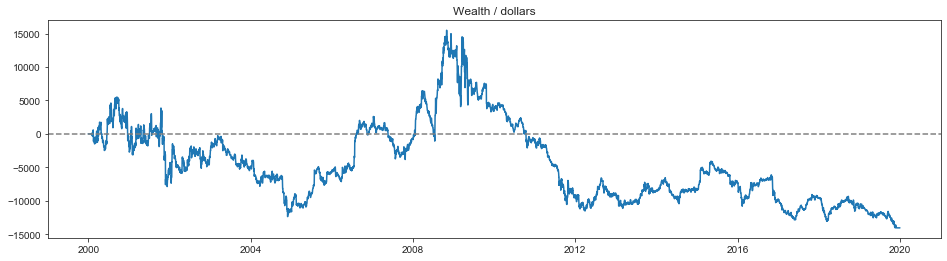

In [8]:
plt.figure(figsize=(16, 4))
plt.plot(wealth)
plt.axhline(0, color='gray', ls='--')
plt.title('Wealth / dollars')
plt.show()

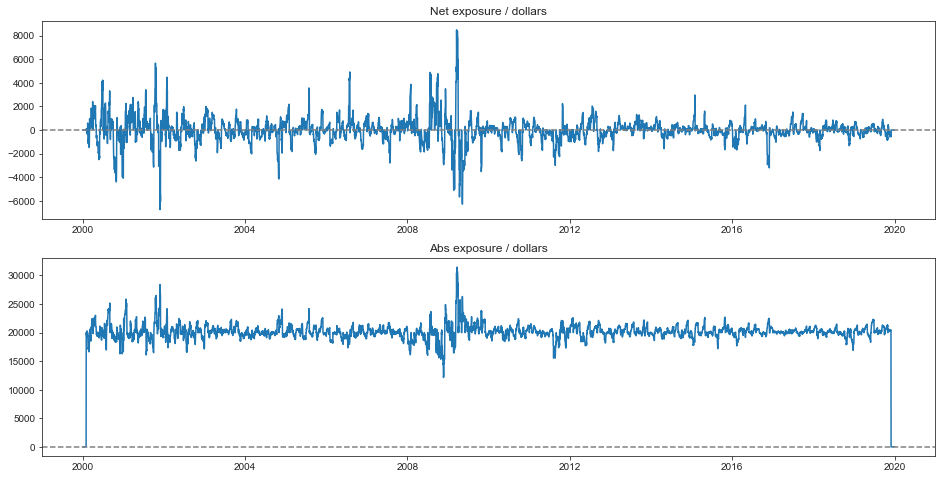

In [9]:
net_exposure = (transaction.cumsum() * universe.prices).sum(axis=1)
abs_exposure = (transaction.cumsum().applymap(abs) * universe.prices).sum(axis=1)

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(net_exposure)
plt.axhline(0, color='gray', ls='--')
plt.title('Net exposure / dollars')

plt.subplot(2, 1, 2)
plt.plot(abs_exposure)
plt.axhline(0, color='gray', ls='--')
plt.title('Abs exposure / dollars')

plt.show()

In [10]:
history.head()

,index,assets,lots,open_dates,close_dates,durations,open_prices,gains
0,0,WMT,245.400220,2000-02-01,2000-03-01,29 days,40.7498,-1650.69
1,0,JPM,-323.370362,2000-02-01,2000-03-01,29 days,30.9243,208.955
2,1,WMT,293.916622,2000-03-01,2000-04-01,31 days,34.0233,1545.12
3,1,AAPL,-2469.461615,2000-03-01,2000-04-01,31 days,4.04947,-422.058
4,2,PG,653.358233,2000-04-01,2000-05-01,30 days,15.3055,618.867


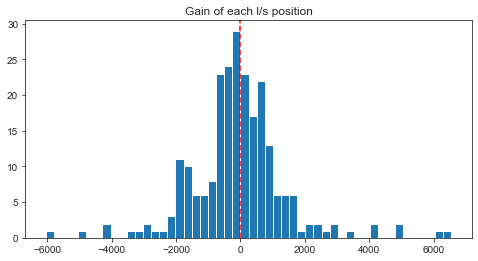

In [11]:
gains = history.gains
gains_agg = history[['index', 'gains']].groupby('index').agg('sum')

plt.figure(figsize=(8, 4))
plt.hist(gains_agg.values, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('Gain of each l/s position')

plt.show()